# DeePC Implementation

### Packages

In [1]:
import osqp
import cvxpy as cp
import numpy as np

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.linalg import hankel
%matplotlib inline

## Data Collection - Car 

In [2]:
NX = 4  # x = x, y, v, yaw
NU = 2  # a = [accel, steer]
WB = 0.2  # [m]
DT = 0.01  # [s] time ticka
MAX_STEER = np.deg2rad(20.0)  # maximum steering angle [rad]
MIN_STEER = -np.deg2rad(20.0)
MAX_DSTEER = np.deg2rad(30.0)  # maximum steering speed [rad/s]
MAX_SPEED = 55.0 / 3.6  # maximum speed [m/s]
MIN_SPEED = -20.0 / 3.6  # minimum speed [m/s]
MAX_ACCEL = 1.0  # maximum accel [m/ss]
MIN_ACCEL = -1.0

# C = np.array([
#     [1,0,0,0],
#     [0,1,0,0]
# ])

C = np.array(
    [1,0,0,0]
)

def get_linear_model_matrix(v, phi, delta):

    A = np.zeros((NX, NX))
    A[0, 0] = 1.0
    A[1, 1] = 1.0
    A[2, 2] = 1.0
    A[3, 3] = 1.0
    A[0, 2] = DT * np.cos(phi)
    A[0, 3] = - DT * v * np.sin(phi)
    A[1, 2] = DT * np.sin(phi)
    A[1, 3] = DT * v * np.cos(phi)
    A[3, 2] = DT * np.tan(delta) / WB

    B = np.zeros((NX, NU))
    B[2, 0] = DT
    B[3, 1] = DT * v / (WB * np.cos(delta) ** 2)

    h = np.zeros(NX)
    h[0] = DT * v * np.sin(phi) * phi
    h[1] = - DT * v * np.cos(phi) * phi
    h[3] = - DT * v * delta / (WB * np.cos(delta) ** 2)

    return A, B, h



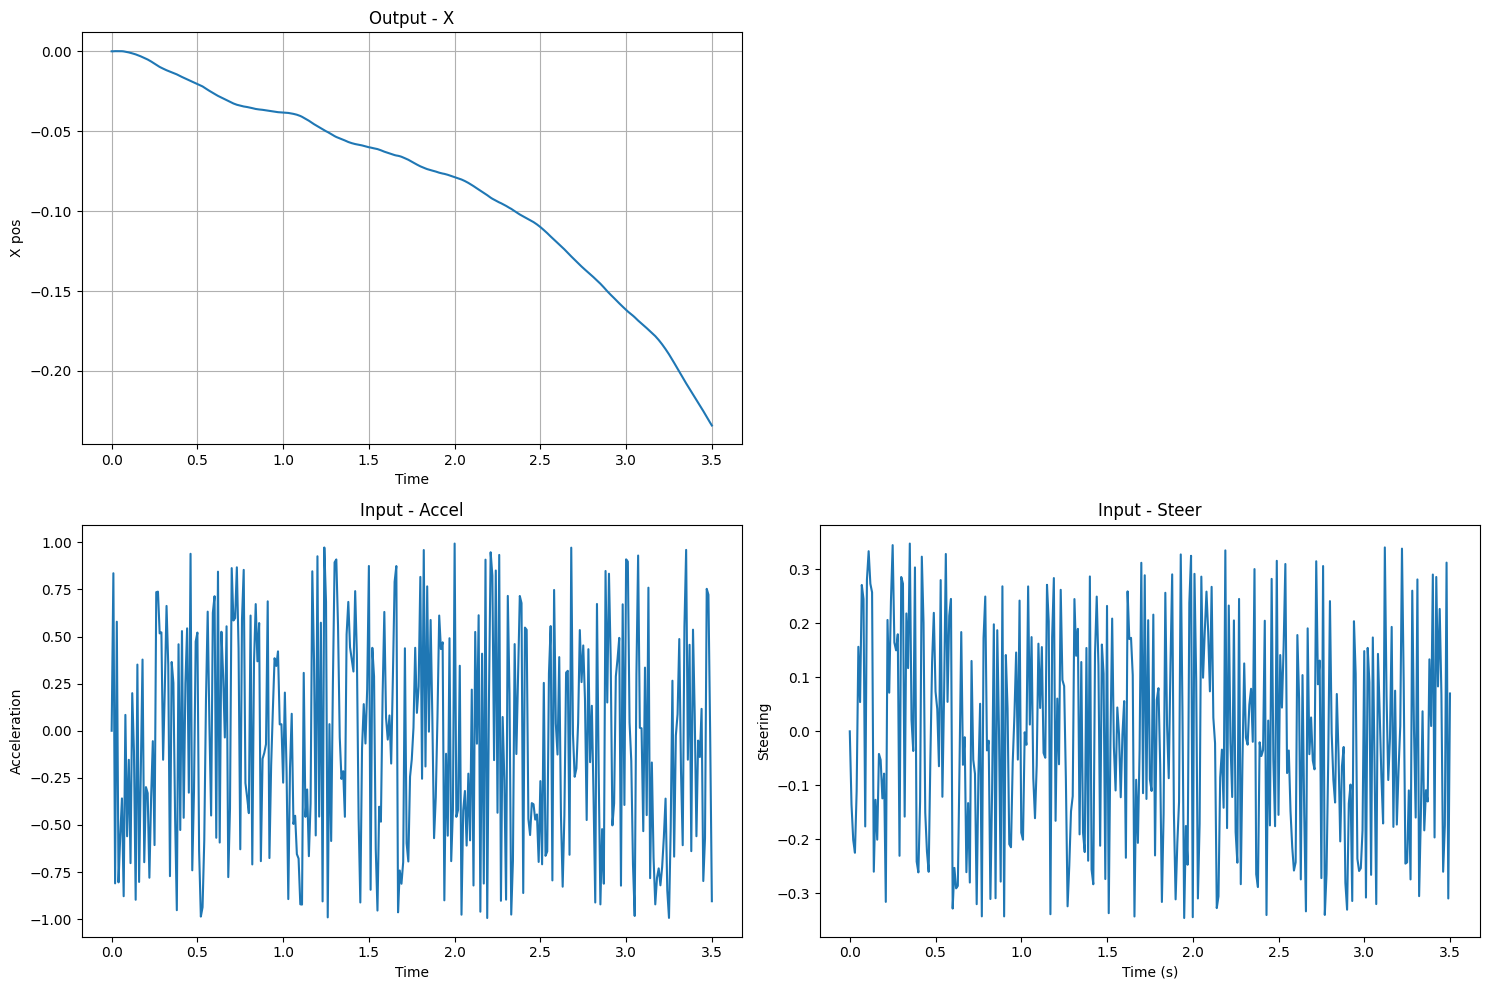

In [3]:
x_i = np.array([0,0,0,0])
x = x_i
y_i = C@x_i
y_T = [y_i]
u_T = [[0,0]]
T = 350

for i in range(0,T):
  a = np.random.uniform(low=MIN_ACCEL, high=MAX_ACCEL)
  # a = 1
  # a = np.random.normal(loc=0.1, scale=0.3)
  delta = np.random.uniform(low=MIN_STEER, high=MAX_STEER)
  u = [a, delta]
  A, B, h = get_linear_model_matrix(x[2],x[3],u[1])
  x = A@x + B@u + h
  y = C@x
  y_T.append(y)
  u_T.append(u)

plt.rcParams["figure.figsize"] = (15,10)

time = np.array(list(range(0,T+1)))*DT
# u_time = np.array(list(range(0,T)))*DT
plt.subplot(2,2,1)
plt.grid('on')
plt.plot(time, y_T)
plt.xlabel('Time')
plt.ylabel("X pos")
plt.title("Output - X")

u_T = np.array(u_T)
plt.subplot(2,2,3)
plt.plot(time, u_T[:,0])
plt.xlabel('Time')
plt.ylabel("Acceleration")
plt.title("Input - Accel")

plt.subplot(2,2,4)
plt.plot(time, u_T[:,1])
plt.xlabel('Time (s)')
plt.ylabel("Steering")
plt.title("Input - Steer")
plt.tight_layout()

plt.show()

In [ ]:
T_ini = 4
n = 4
N = 100
L = T_ini + N + n

H = hankel(u_T[0:L,:], u_T[L:,:])
print(f'H has rank {np.linalg.matrix_rank(H)} and shape {H.shape}')


: 

In [ ]:
L = T_ini + N
U = hankel(u_T[0:L,:], u_T[L:,1])
Y = hankel(y_T[0:L], y_T[L:])

Up = U[0:(2*T_ini), :]
Uf = U[(2*T_ini):, :]
print(f'U = {U.shape}, Up = {Up.shape}, Uf = {Uf.shape}')

Yp = Y[0:T_ini, :]
Yf = Y[T_ini:, :]
print(f'Y = {Y.shape}, Yp = {Yp.shape}, Yf = {Yf.shape}')

u_ini = np.zeros(T_ini*2)
y_ini = np.zeros(T_ini)

A = np.vstack([Up, Yp, Uf, Yf])

: 

In [ ]:
g = cp.Variable(T - T_ini - N + 1)
u = cp.Variable(2*N)
y = cp.Variable(N)
b = np.hstack([u_ini, y_ini, u, y])

r = np.ones(N)
Q = np.eye(N)
R = np.eye(2*N)

cost = cp.quad_form(y - r, Q) + cp.quad_form(u,R)

constraints = [
    Up @ g == u_ini,
    Yp @ g == y_ini,
    Uf @ g == u,
    Yf @ g == y,
    # u[1,:] <= MAX_STEER,
    # u[0,:] <= MAX_ACCEL
]

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(solver=cp.OSQP, verbose=True)
prob.variables()



: 

In [ ]:
y = prob.variables()[0].value
u = prob.variables()[1].value.reshape((100,2))

time = np.array(list(range(0,N)))

plt.subplot(1,2,1)
plt.plot(time,y,label=['x_pos'])
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.ylim((-1,2))
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(time, u, label=['acceleration', 'steering'])
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.title("Actuation")
plt.ylim((-1.5,1.5))
plt.tight_layout()

: 

## Trying with CartPole

In [40]:
import gym
import mujoco_py

env = gym.make('InvertedPendulum-v4')
obs = env.reset()


ud = []
yd = []
done = False
for i in range(27):
    action = env.action_space.sample()
    obs, rew, done, info, _ = env.step(action)
    ud.append(action)
    yd.append(obs)

env.close()



/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [41]:
T_ini = 4
n = 4
N = 5
env.close()
T = len(ud)
ud = np.array(ud)
yd = np.array(yd)

print(f'yd shape : {yd.shape}   ud shape : {ud.shape}')

L = T_ini + N + n
H = hankel(ud[0:L], ud[L:])
print(f'H has rank {np.linalg.matrix_rank(H)} and shape {H.shape}')

yd shape : (27, 4)   ud shape : (27, 1)
H has rank 13 and shape (13, 14)


In [42]:
L = T_ini + N
y_ = yd.reshape((108,1))
U = hankel(ud[0:L], ud[L:])
Y = hankel(yd[0:L,:], yd[L:,1])

Up = U[0:T_ini, :]
Uf = U[T_ini:, :]
print(f'U = {U.shape}, Up = {Up.shape}, Uf = {Uf.shape}')

Yp = Y[0:4*T_ini, :]
Yf = Y[4*T_ini:, :]
print(f'Y = {Y.shape}, Yp = {Yp.shape}, Yf = {Yf.shape}')

u_ini = np.zeros(T_ini)
y_ini = np.zeros(T_ini*4)

U = (9, 18), Up = (4, 18), Uf = (5, 18)
Y = (36, 18), Yp = (16, 18), Yf = (20, 18)


## Solver

In [56]:
g = cp.Variable(T - T_ini - N)
u = cp.Variable(N)
y = cp.Variable(N*4)
sig_y = cp.Variable(4*T_ini)

Q = np.eye(N*4)
R = np.eye(N)*0.1
x_lower = np.ones(N)*0
x_upper = np.ones(N)*3


cost = cp.quad_form(y, Q) + cp.quad_form(u,R) + cp.norm1(g)*10 + cp.norm1(sig_y)*0.1

env = gym.make('InvertedPendulum-v4')
obs = env.reset()
done = False
yT = []
uT = []

for i in range(30):

  constraints = [
    Up @ g == u_ini,
    Yp @ g == y_ini + sig_y,
    Uf @ g == u,
    Yf @ g == y,
    # A@g == b,
    # cp.abs(u[::2]) <= accel_constraint,
    # cp.abs(u[1::2]) <= steer_constraint,
    # y <= x_upper,
    # y >= x_lower
  ]

  prob = cp.Problem(cp.Minimize(cost), constraints)
  prob.solve(solver=cp.OSQP, verbose=False)

  for i in range(T_ini):
    action = prob.variables()[1].value[i]
    # print(action)
    obs,_,_,_,_ = env.step([action])
    uT.append(action)
    yT.append(obs)

  u_ini = np.array(ud[-4:]).reshape(4,)
  y_ini = np.array(yT[-4:][:]).reshape(16,)




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


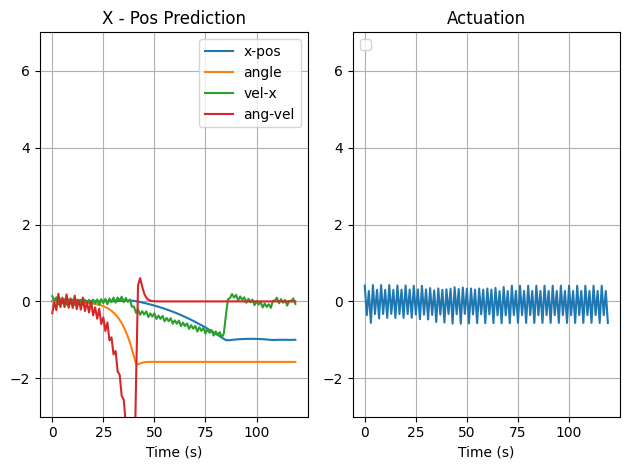

In [57]:
# time = np.array(list(range(0,N)))
# y = prob.variables()[0].value
# u = prob.variables()[1].value
yT = np.array(yT)
yT = yT.reshape((120,4))
plt.subplot(1,2,1)
plt.plot(range(0,120), yT, label=['x-pos', 'angle', 'vel-x', 'ang-vel'])
plt.legend(loc="upper right")
plt.xlabel('Time (s)')
plt.title("X - Pos Prediction")
plt.ylim((-3,7))
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,120), uT)
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.title("Actuation")
plt.ylim((-3,7))
plt.grid('on')
plt.tight_layout()

plt.show()